# Ranking Notebook for SC3-Atmospheres
This notebook integrates the internal ranking algorithm for the SC3-Atmospheres program with the program-wide prioritization algorithm.

## Summary of SC3-Atmospheres internal ranking algorithm
### Ranking TOIs and known planets
First, we join a list of current TOIs (which can optionally exclude QLP targets) with a list of known planets. We divide the combined list into bins of planet radius, insolation flux, and stellar effective temperature. We sort targets in each bin by the ratio of their TSM value (a proxy for Webb transmission spectra SNR, see [Kempton et al. 2018](https://arxiv.org/abs/1805.03671)) and the total estimated exposure time needed on HIRES to achieve a 5-$\sigma$ mass, $t_\mathrm{HIRES}$:

\begin{align}
X & \equiv \frac{\mathrm{TSM}}{t_\mathrm{HIRES}}.
\end{align}

$t_\mathrm{HIRES}$ is calculated using the theoretical values for the number of observations needed to achieve a certain detection SNR, as seen on page 19 of [Plavchan et al. 2015](https://arxiv.org/abs/1503.01770) and equation 9 in [Howard & Fulton 2016](https://arxiv.org/abs/1606.03134). $N_\mathrm{obs}$ is an underestimate (potentially by a factor of 10 or more) but since we're just using it as a way to rank targets relative to eachother, it should be fine for now.

$t_\mathrm{HIRES}$ is a function of the target's $V$ magnitude, a target number of exposure meter counts (in thousands), $n_\mathrm{counts}$, and the planet's radius, $R_\mathrm{pl}$ (which is used in the empirical mass-radius relation from [Chen & Kipping 2017](https://arxiv.org/abs/1603.08614)):

\begin{align}
t_\mathrm{HIRES} & = t_\mathrm{ob}(V, n_\mathrm{counts}) \times N_\mathrm{obs}(n_\mathrm{counts}, R_\mathrm{pl}) \\
& = t_\mathrm{ob}(V, n_\mathrm{counts}) \times \Big(\frac{5 \cdot \sigma(n_\mathrm{counts})}{K(R_\mathrm{pl})}\Big)^2,
\end{align}
where $t_\mathrm{ob}$ is the exposure time (in seconds) of a single observation, $N_\mathrm{obs}$ is the number of observations needed to achieve the 5-$\sigma$ mass measurement, $\sigma$ is the typical velocity uncertainty (in m/s) on a single RV measurement, and $K$ is the estimated semi-amplitude of the planetary radial velocity signal (in m/s). Dependencies are noted in parentheses following variables.

As noted before, $N_\mathrm{obs}$ is calculated using the equation on page 19 of [Plavchan et al. 2015](https://arxiv.org/abs/1503.01770). Using Equation 9 from [Howard & Fulton 2016](https://arxiv.org/abs/1606.03134) produces the same rankings. 

$\sigma$ is *roughly* converted from exposure meter counts to velocity precision using https://caltech-ipac.github.io/hiresprv/performance.html. As fiducial values, for all targets we use $n_\mathrm{counts} = 250$ and $\sigma(n_\mathrm{counts} = 250) \approx 1$ m s$^{-1}$. This is also an underestimate of $\sigma$, and for targets that already have RVs on Jump, we could calculate $\sigma$ directly, but for now this should be fine because we're using the same standard for all targets.

**TL;DR**: A larger $X$ value $\rightarrow$ higher priority.

Each bin in planet radius, insolation flux, and stellar effective temperature gets sorted by $X$, and the top three targets get assigned priority 1, 2, and 3.

### Merging our ranked, binned known planets and TOIs with selected_TOIs
Now that each bin of known planets and TOIs has priority 1, 2, and 3 targets, we merge our list of targets with the those listed in selected_TOIs. This eliminates the known planets, leaving only the ranked TOIs. At this step we also filter out TOIs that are also known planets, as well as TOIs that failed spectroscopic vetting or AO vetting, and TOIs with 'hires_prv' = 'no'.

The resulting list is sorted by bin priority number and by X value within each bin. This list is used as the initial target list that gets sent to the program-wide prioritization algorithm. The list being used can be found in ../data/sc3/.

## Picking the next highest priority SC3 target
In ranking_sc3.py, when it's SC3's turn to pick, get_highest_priority_sc3() (a member function of NewSample) gets called. The general idea behind get_highest_priority_sc3() is:

On each SC3 pick:
- Look at the target that was picked previously
    - If it wasn't picked by SC3 AND it is in our initial target list
        - Reward this target by multiplying its X value by the total number of times it's been picked by other programs
- If there are targets remaining in the VIP target list, pick the next one
- If there aren't any VIP targets remaining, pick the target that has the highest X value of the highest remaining priority level
- Remove the pick from the initial target list


-Joey, 03/25/20

Save for a few notes to self, the rest of the notebook is a copy of ranking.ipynb, with SC3 chosen as the highlighted science case.

In [1]:
%pylab inline
import sys
sys.path.append('./')
sys.path.append('../')
from sim.ranking_sc3 import get_info, ranking_scheme, compare_hists # Note: Using the SC3-specific ranking.py file here
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib



>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


## Load TKS selected_TOIs + program details

In [2]:
candidates, programs = get_info()

print(candidates.columns.values.tolist())

['tic', 'toi', 'cps', 'ra', 'dec', 'tmag', 'vmag', 'jmag', 'smass', 'sradius', 't_eff', 'evol', 'ast_det', 'd', 'ruwe', 'rv', 'rv_err', 'rot_per', 'rot_amp', 'vsini', 'rhk', 'shk', 'per', 'per_err', 'epoch', 't14', 'rp', 'sinc', 'mp', 'sig_id', 'significance', 'kexp', 'n_rv', 'template', 'h', 'counts', 'texpmin', 'twithoverheads', 'nobs', 'ttothr', 'hexp', 'priority', 'pipeline', 'disp', 'public_comments', 'tks_comments', 'vetting', 'ao_vet', 'hires_prv', 'apf_prv', 'prv_plan', 'hires_next_run_notes', 'nobs_goal_keck', 'min_cadence_keck', 'exp_keck', 'texp_keck', 'n_shots_keck', 'n_visits_night_keck', 'nobs_goal_apf', 'min_cadence_apf', 'exp_apf', 'texp_apf', 'n_shots_apf', 'n_visits_night_apf', 'is_visible', 'npl', 'in_other_programs', 'in_SC1A', 'in_SC1B', 'in_SC1C', 'in_SC1D', 'in_SC1E', 'in_SC2A', 'in_SC2Bi', 'in_SC2Bii', 'in_SC2C', 'in_SC3', 'in_SC4A', 'in_SC4B', 'k_exp', 'iexptime', 'texptime', 'overtime', 'tottime', 'sigmajit', 'sigmaphot', 'sigmarv', 'k_err', 'ksig', 'esig']


## View different programs and their prioritizations

In [3]:
print(programs)

                            method  \
SC1A     hires-nobs=60-counts=ramp   
SC1B     hires-nobs=60-counts=ramp   
SC1C     hires-nobs=60-counts=ramp   
SC1D     hires-nobs=60-counts=ramp   
SC1E     hires-nobs=60-counts=ramp   
SC2A       hires-nobs=30-counts=60   
SC2Bi    hires-nobs=60-counts=ramp   
SC2Bii   hires-nobs=60-counts=ramp   
SC2C    hires-nobs=100-counts=ramp   
SC3      hires-nobs=60-counts=ramp   
SC4A     hires-nobs=60-counts=ramp   
SC4B     hires-nobs=60-counts=ramp   

                                                   filter prioritize_by  \
SC1A                                rp > 1.3 and rp < 2.2   actual_cost   
SC1B      rp > 1. and rp < 4. and per > 1. and per < 100.   actual_cost   
SC1C                              sinc > 650. and rp < 8.   actual_cost   
SC1D                           sinc < 10 and evol == 'MS'   actual_cost   
SC1E                                           is_visible   actual_cost   
SC2A    rp < 10 and dec > 0 and vmag > 10. and vmag < .

## Run prioritization method

In [4]:
observed, progs = ranking_scheme(candidates, programs)

print(observed)

SC3 had 12 picks
          tic   toi  priority  \
0   453211454   509         1   
1    98796344   455         2   
2   298647682  1643         3   
3    21535395  1776         4   
4   302773669  1573         5   
5   332064670  1773         6   
6   467179528  1266         7   
7   230127302  1246         8   
8   116483514  1411         9   
9   408618999  1736        10   
10   31374837   431        11   
11  159418353  1739        12   
12  468828873  1672        13   
13  283722336  1469        14   
14  317548889   480        15   
15  417676622  1290        16   
16  230017325  1363        17   
17   15863518  1713        18   
18  232540264  1247        19   
19  219857012  1742        20   
20  268334473  1691        21   
21  188768068  1462        22   
22  142276270  1136        23   
23  219852882  1346        24   
24   39699648  1778        25   
25  318022259  1730        26   
26  293954617  1430        27   
27  428679607  1669        28   
28  311121985  1660       

**Joey note to self, 03/25/20**

Are the programs listed above programs these targets belong to, or programs that each picked this target?
It looks like targets above belong to a lot of programs, but I don't see get_highest_sc3() finding a lot of boost factors (see ranking_sc3.py) for targets that have already been picked (when I step through each pick individually with pdb). Is this a problem on my end, or are the program memberships shown here indicative of what program each target belongs to on e.g. Jump, but not that it was necessarily picked by that program on this iteration of the algorithm?

## As a sanity check: how much time and targets are left in each program
Please note: if there are no targets left/relevant in a program (i.e. SC1D/HZ only has 1 relevant target right now), it will change the remaining hours to 0.0 so it will not continue to pick that program in the process - so for now, do not be alarmed if you see zero remaining time in your program! It's just to make sure the process doesn't break

In [5]:
print(programs.remaining_hours)

SC1A      0.0
SC1B      0.0
SC1C      0.0
SC1D      0.0
SC1E      0.0
SC2A      0.0
SC2Bi     0.0
SC2Bii    0.0
SC2C      0.0
SC3       0.0
SC4A      0.0
SC4B      0.0
Name: remaining_hours, dtype: float64


In [6]:
print(programs.n_targets_left)

SC1A       14
SC1B       81
SC1C       14
SC1D        0
SC1E      126
SC2A       30
SC2Bi     122
SC2Bii    126
SC2C        1
SC3       143
SC4A        0
SC4B       11
Name: n_targets_left, dtype: int64


## How many targets does each program have

In [7]:
df = pd.read_csv('../data/program_overlap.csv')
print('Out of %d total targets:'%len(df))
for science in programs.index.values.tolist():
    a = df['in_'+science].values.tolist()
    d = {x:a.count(x) for x in a}
    print(' - %s has %d targets'%(science, d['X']))

Out of 60 total targets:
 - SC1A has 18 targets
 - SC1B has 25 targets
 - SC1C has 13 targets
 - SC1D has 5 targets
 - SC1E has 29 targets
 - SC2A has 10 targets
 - SC2Bi has 33 targets
 - SC2Bii has 29 targets
 - SC2C has 16 targets
 - SC3 has 12 targets
 - SC4A has 8 targets
 - SC4B has 4 targets


## Check overlap

In [8]:
df

,tic,toi,priority,in_SC1A,in_SC1B,in_SC1C,in_SC1D,in_SC1E,in_SC2A,in_SC2Bi,in_SC2Bii,in_SC2C,in_SC3,in_SC4A,in_SC4B,total_programs
0,453211454,509,1,-,X,-,-,X,-,X,X,-,X,-,-,5
1,98796344,455,2,X,X,-,X,-,-,-,-,-,X,-,-,4
2,298647682,1643,3,-,X,-,X,X,-,X,X,-,-,-,-,5
3,21535395,1776,4,X,X,-,-,X,-,X,X,-,-,-,-,5
4,302773669,1573,5,-,-,-,-,X,-,X,X,-,-,X,-,4
5,332064670,1773,6,X,-,X,-,X,-,X,X,-,-,-,-,5
6,467179528,1266,7,-,-,-,X,-,-,-,-,X,-,-,-,2
7,230127302,1246,8,-,-,-,-,-,-,-,-,X,-,-,-,1
8,116483514,1411,9,X,-,-,-,-,X,X,X,-,-,-,-,4
9,408618999,1736,10,-,X,-,-,X,-,X,X,-,-,-,X,5


## Check targets selected for a given program

In [9]:
science_case = 'SC3'

df = pd.read_csv('../data/program_overlap.csv')
program = df.query("in_%s == 'X'"%science_case)

# how many have 5 or more programs?
query = program.query('total_programs >= 5')
print('%d picked targets had large overlap (>= 5 programs) with other programs'%len(query))

5 picked targets had large overlap (>= 5 programs) with other programs


## Get star/planet information from original selected_TOIs list

In [10]:
limit_columns_printed = ['tmag', 'jmag', 'ruwe', 'rot_per', 'vsini', 'rhk', 'shk', 'n_rv', 'template', 'h', 'counts', 
                         'texpmin', 'twithoverheads', 'ttothr', 'hexp', 'pipeline', 'public_comments', 'tks_comments', 
                         'vetting', 'hires_prv', 'apf_prv', 'prv_plan', 'hires_next_run_notes', 'nobs_goal_keck', 
                         'min_cadence_keck', 'exp_keck', 'n_shots_keck', 'n_visits_night_keck', 'nobs_goal_apf', 
                         'min_cadence_apf', 'exp_apf', 'n_shots_apf', 'n_visits_night_apf', 'is_visible', 'in_SC1A', 
                         'in_SC1B', 'in_SC1C', 'in_SC1D', 'in_SC1E', 'in_SC2A', 'in_SC2Bi', 'in_SC2Bii', 'in_SC2C', 
                         'in_SC3', 'in_SC4A', 'in_SC4B', 'iexptime', 'texptime', 'overtime', 'sigmajit', 'sigmaphot']

science_filter = ''
for tic in program.tic.values.tolist():
    science_filter += 'tic == %d or '%tic
science_filter = science_filter[:-4]

results = candidates.query(science_filter)
results.drop(limit_columns_printed, axis=1, inplace=True)
print(results)

           tic      toi       cps          ra        dec   vmag  smass  \
8     98796344   455.01    GJ3193   45.464200 -16.593400  10.60   0.25   
12   453211454   509.01     63935  117.924970   9.386054   8.60   0.98   
13   407966340   554.01     25463   60.747939   9.208501   6.90   1.25   
15   377064495   561.01   T000561  148.185590   6.216373  10.30   0.95   
16   377064495   561.02   T000561  148.185590   6.216373  10.30   0.95   
17   377064495   561.03   T000561  148.185590   6.216373  10.30   0.95   
25   142276270  1136.01   T001136  192.184889  64.855319   9.50   1.03   
26   142276270  1136.02   T001136  192.184889  64.855319   9.50   1.03   
27   142276270  1136.03   T001136  192.184889  64.855319   9.50   1.03   
89   269701147  1339.01    191939  302.023979  66.850576   9.00   0.95   
90   269701147  1339.02    191939  302.023979  66.850576   9.00   0.95   
91   269701147  1339.03    191939  302.023979  66.850576   9.00   0.95   
99   199444169  1410.01   T001410  334

# Compare to the full sample

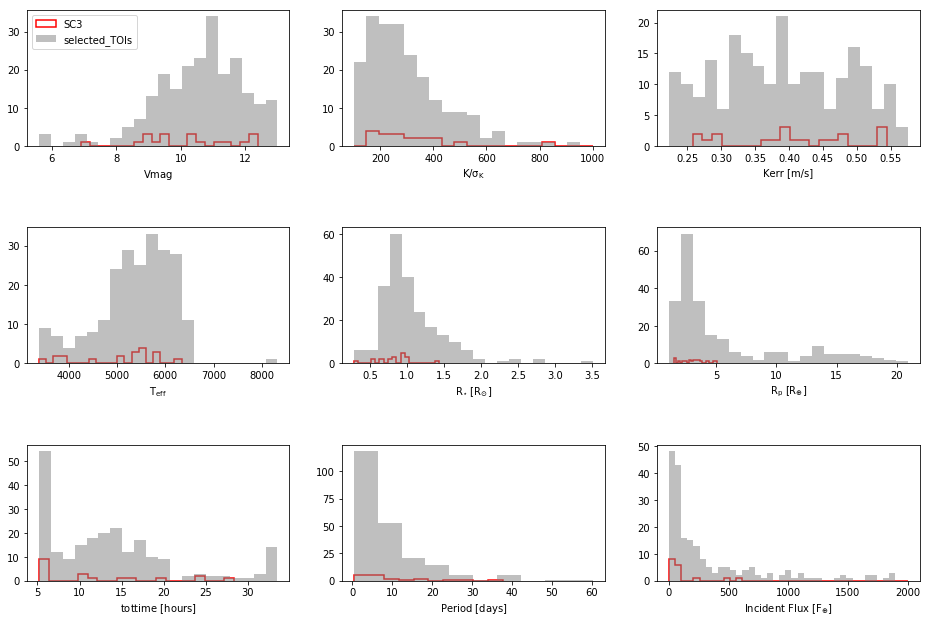

In [12]:
program_plot_kws = {'label': science_case, 'color': 'red',
                 'histtype': 'step', 'lw': 1.5}
full_plot_kws  = {'label': 'selected_TOIs', 'color': 'grey', 'alpha': 0.5}

compare_hists([[results, program_plot_kws], [candidates, full_plot_kws]])

#plt.savefig('plots/%s.png'%science_case, dpi=250)